In [2]:
from pathlib import Path
from datetime import datetime
import json
import simplejson

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [5]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [6]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [7]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [11]:
def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 
        'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_unkind_mutation_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate, 
        'kind_mutations': False,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=250, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

## Investigating the effect of message mutation:

In [14]:
class VaryPMutateExperiment(MetaExperiment):
    
    def __init__(self, 
                 num_intervals=5, 
                 p_mutate_vals = None,
                 save_location=None, 
                 **experiment_kwargs):
        self.name = 'vary_pm_experiment'
        
        self.num_experiments = num_intervals + 1
        if p_mutate_vals is not None:
            self.num_experiments = len(p_mutate_vals)
        
        p_mutate_vals = p_mutate_vals or [
            i/num_intervals for i in range(self.num_experiments)
        ]
        self.experiments = [
            {
                'p_mutate': p_mutate,
                'experiment': MetaExperiment(
                    p_mutate=p_mutate, 
                    print_prehistory=self.print_history,
                    name=f'meta_experiment_pm={p_mutate}',
                    export_location=None if save_location is None else \
                                    f'{save_location}/pm={p_mutate}',
                    **experiment_kwargs
                ),
                'status': 'Not Run',
                'results': None,
                'index': i,
            }
            for i, p_mutate in enumerate(p_mutate_vals)
        ]
        
        self.save_location = save_location
        if save_location is not None:
            self.load_history(save_location)
    
    def get_experiment_results(self, meta_experiment):
        return meta_experiment.results

    def _get_results(self):
        return None
    
    def print_prehistory(self):
        pass
    
    def load_sub_experiment(self, path):
        history = json.load((path / 'training_history.json').open(mode='r'))
        
        results_path = path / 'results.json'
        if results_path.exists():
            results = json.load(results_path.open(mode='r'))
        else:
            results = [
                item['test_metrics'] for item in history
                if 'test_metrics' in item
            ][-1]
        
        config_path = path / 'config.json'
        if config_path.exists():
            config = json.load(config_path.open(mode='r'))
            agent = Agent(config['play_params']['channel_size'], NUM_CLASSES)
        
            agent.load_weights(str(path / 'agent_weights'))

            config['loss_fn'] = student_pred_matches_test_class
        else:
            agent = None
            config = {'epochs_optimised': len(history)}

        kwargs = {
            k: v for k, v in config.items()
            if k not in ['epochs_optimised', 
                         'optimiser_config',
                         'optimise_agents_separately']
        }
            
        experiment = Experiment(
            generate_train_batch, generate_test_batch,
            student=agent,
            teacher=agent,
            **kwargs
        )
        experiment.epoch = config['epochs_optimised']
        experiment.training_history = history
        experiment.results = results
        
        return experiment
    
    def load_meta_exp(self, meta_exp_path):
        metadata = json.load((meta_exp_path / 'meta.json').open(mode='r'))
        results = json.load((meta_exp_path / 'results.json').open(mode='r'))
        if 'experiment_config' in metadata:
            p_mutate = metadata['experiment_config']['play_params']['p_mutate']
        elif 'p_mutate' in metadata:
            p_mutate = metadata['p_mutate']
        
        i, *_ = [i for i, item in enumerate(self.experiments)
                 if item['p_mutate'] == p_mutate]
        
        self.experiments[i]['status'] = 'Complete'
        self.experiments[i]['results'] = results['zs_coord_f1_scores']
        meta_exp = self.experiments[i]['experiment']
        meta_exp.results = results['zs_coord_f1_scores']

        j = 0
        for sub_exp_path in meta_exp_path.glob('*'):
            try: 
                if not sub_exp_path.is_file():
                    meta_exp.experiments[j]['experiment'] = \
                        self.load_sub_experiment(sub_exp_path)
                    meta_exp.experiments[j]['status'] = 'Complete' 
                    meta_exp.experiments[j]['results'] = \
                        meta_exp.experiments[j]['experiment'].results
                    j += 1
            except:
                pass
            
    def load_history(self, history_location):
        exp_path = Path(history_location)
        for meta_exp_path in exp_path.glob('*'):
            results_path = meta_exp_path / 'results.json'
            history_path = meta_exp_path / 'training_history.json'
            if results_path.exists() or history_path.exists():
                self.load_meta_exp(meta_exp_path)
    
    def export_experiment(self, experiment):
        if self.save_location is not None:
            experiment_config = \
                experiment.experiments[0]['experiment'].get_config()
            
            i, *_ = [i for i, x in enumerate(self.experiments)
                     if x['experiment'] == experiment]
            meta_data = {
                'index': i,
                'experiment_config': experiment_config
            }
            meta_data_path = Path(f'{experiment.export_location}/meta.json')
            with meta_data_path.open(mode='w') as f:
                json.dump(meta_data, f)
                
            results = {
                'zs_coord_f1_scores': experiment.results
            }
            results_path = Path(f'{experiment.export_location}/results.json')
            with results_path.open(mode='w') as f:
                json.dump(results, f)

            print('Saved experiment data at:', experiment.export_location)

In [9]:
BASE_FOLDER = './experiments/message_mutation_1'
# EXPERIMENT_FOLDER = f'{BASE_FOLDER}/{datetime.now().strftime("%d-%m_%H-%M")}'
# EXPERIMENT_FOLDER = "./experiments/message_mutation_3"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/24-09_09-40"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/03-10_02-03"
Path(EXPERIMENT_FOLDER).mkdir(exist_ok=True)
EXPERIMENT_FOLDER

'./experiments/message_mutation_1/03-10_02-03'

In [22]:
vary_pm_experiment = VaryPMutateExperiment(save_location=EXPERIMENT_FOLDER,
                                           p_mutate_vals=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                           max_epochs=100,
                                           create_experiment_fn=create_self_play_experiment)

In [23]:
vary_pm_experiment.run()

Running vary_pm_experiment...
meta_experiment_pm=0.0 results:  [0.4875, 0.2875, 0.21875, 0.58125, 0.28125, 0.4375]
meta_experiment_pm=0.2 results:  [1.0, 0.95625, 1.0, 0.88125, 1.0, 0.91875]
meta_experiment_pm=0.4 results:  [0.75, 0.675, 0.775, 0.81875, 0.6125, 0.85625]
meta_experiment_pm=0.6 results:  [0.875, 0.6375, 0.79375, 0.94375, 0.66875, 0.925]
meta_experiment_pm=0.8 results:  [0.4625, 0.43125, 0.525, 0.4625, 0.46875, 0.44375]
meta_experiment_pm=1.0 results:  [0.4875, 0.5625, 0.4625, 0.2875, 0.61875, 0.29375]
Run Stopped.


In [24]:
grand_total = 0
for item_1 in vary_pm_experiment.experiments:
    for item_2 in item_1['experiment'].experiments:
        total_time = sum([
            x['seconds_taken']
            for x in item_2['experiment'].training_history
        ])
        print(int(total_time / 3600), 'hours,', int(total_time / 60) % 60, 'mins and', 
              int(total_time) % 60, 'seconds taken for experiment', 
              f"pm={item_1['p_mutate']}_{item_2['index']}")
        grand_total += total_time
    print()
    
print(int(grand_total / 3600), 'hours,', int(grand_total / 60) % 60, 'mins and', 
      int(grand_total) % 60, 'seconds taken for whole experiment')

0 hours, 13 mins and 6 seconds taken for experiment pm=0.0_0
0 hours, 13 mins and 14 seconds taken for experiment pm=0.0_1
0 hours, 14 mins and 34 seconds taken for experiment pm=0.0_2

0 hours, 13 mins and 34 seconds taken for experiment pm=0.2_0
0 hours, 12 mins and 56 seconds taken for experiment pm=0.2_1
0 hours, 12 mins and 45 seconds taken for experiment pm=0.2_2

0 hours, 12 mins and 47 seconds taken for experiment pm=0.4_0
0 hours, 12 mins and 52 seconds taken for experiment pm=0.4_1
0 hours, 12 mins and 49 seconds taken for experiment pm=0.4_2

0 hours, 13 mins and 1 seconds taken for experiment pm=0.6_0
0 hours, 12 mins and 56 seconds taken for experiment pm=0.6_1
0 hours, 13 mins and 0 seconds taken for experiment pm=0.6_2

0 hours, 12 mins and 59 seconds taken for experiment pm=0.8_0
0 hours, 13 mins and 3 seconds taken for experiment pm=0.8_1
0 hours, 12 mins and 52 seconds taken for experiment pm=0.8_2

0 hours, 12 mins and 55 seconds taken for experiment pm=1.0_0
0 hours

In [25]:
zs_coord_df = pd.DataFrame([
    {
        'Mutation Probability': item['p_mutate'],
        'Zero-Shot Coordination Score': score,
    }
    for item in vary_pm_experiment.experiments
    if item['status'] == 'Complete'
    for score in item['results']
])

In [26]:
self_play_df = pd.DataFrame([
    {
        'Mutation Probability': item_1['p_mutate'],
        'Self-play Performance': item_2['results']['mean_ground_truth_f1'],
    }
    for item_1 in vary_pm_experiment.experiments
    if item_1['status'] == 'Complete'
    for item_2 in item_1['experiment'].experiments
    if item_2['status'] == 'Complete'
])

In [27]:
sns.reset_defaults()
sns.set()

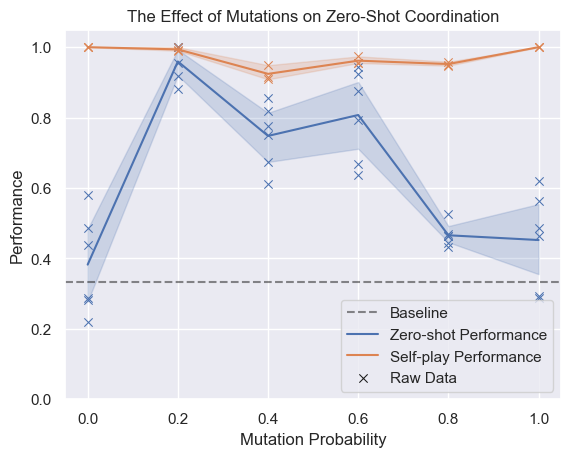

In [39]:
ax = sns.lineplot(x=[-2, 2], y=[1/NUM_CLASSES, 1/NUM_CLASSES], color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
ax.lines[0].set_linestyle("--")
sns.lineplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=zs_coord_df, label='Zero-shot Performance')
sns.scatterplot(x='Mutation Probability', y='Zero-Shot Coordination Score', data=zs_coord_df, marker='x')
sns.lineplot(x='Mutation Probability', y='Self-play Performance', data=self_play_df, label='Self-play Performance')
sns.scatterplot(x='Mutation Probability', y='Self-play Performance', data=self_play_df, marker='x')
sns.scatterplot(x='x', y='y', data=pd.DataFrame([{'x': 100, 'y': 100}]), color=(0.1, 0.1, 0.1, 0.5), marker='x', label='Raw Data')
plt.ylim([0, 1.05])
plt.xlim([-.05, 1.05])
plt.title('The Effect of Mutations on Zero-Shot Coordination')
plt.ylabel('Performance')
plt.xlabel('Mutation Probability')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc=4)
plt.show()

In [29]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"p_m={item_1['p_mutate']}",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Train Loss': training_item['loss']
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history) 
])
df_train.head()

,Epoch,Experiment,Subexperiment,Train Loss
0,0,p_m=0.0,subexperiment_0,3.836313
1,1,p_m=0.0,subexperiment_0,3.821975
2,2,p_m=0.0,subexperiment_0,3.802912
3,3,p_m=0.0,subexperiment_0,3.841363
4,4,p_m=0.0,subexperiment_0,3.759899


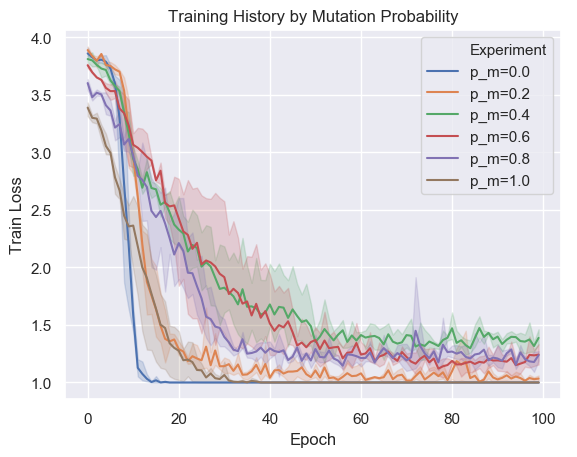

In [30]:
sns.lineplot(x='Epoch', y='Train Loss', hue='Experiment', 
             data=df_train);
#              data=df_train[df_train['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training History by Mutation Probability')
plt.show()

In [121]:
df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"$p_m={item_1['p_mutate']}$",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Performance': training_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': training_item['test_metrics']['mean_protocol_diversity'],
    }
    for item_1 in vary_pm_experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history)
    if 'test_metrics' in training_item
])

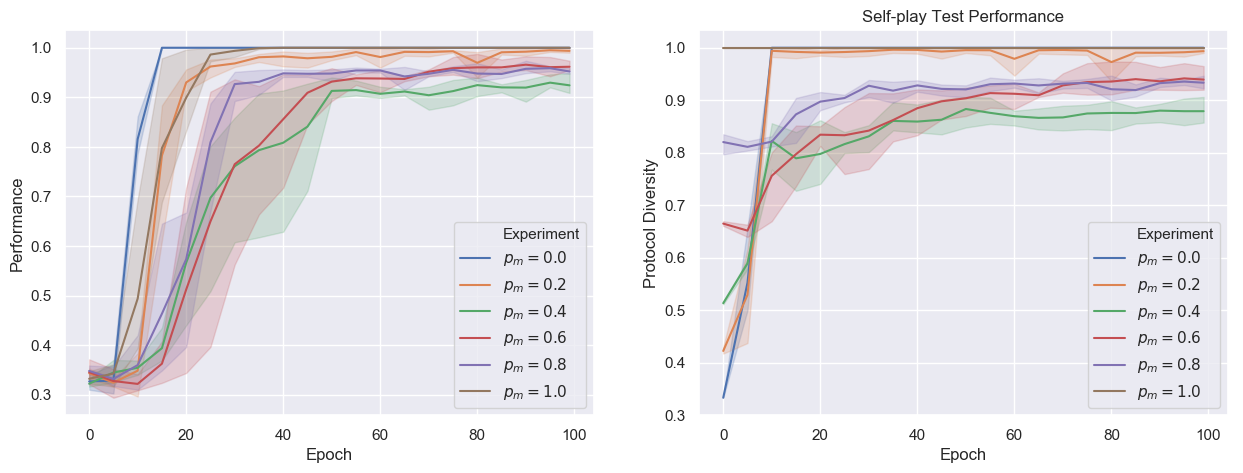

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='Epoch', y='Performance', hue='Experiment', 
             data=df_test, ax=axs[0]);
sns.lineplot(x='Epoch', y='Protocol Diversity', hue='Experiment', 
             data=df_test, ax=axs[1]);
#              data=df_test[df_test['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Self-play Test Performance')
plt.show()

In [56]:
exp = vary_pm_experiment.experiments[2]['experiment'].experiments[1]['experiment']
games_played, test_metrics = exp.run_tests()
test_metrics

{'mean_test_loss': 1.4389039278030396,
 'mean_ground_truth_f1': 0.90375,
 'ground_truth_acc': 0.90375,
 'mean_student_error': 0.1339043378829956,
 'mean_teacher_error': 1.2166798057933192e-07,
 'mean_protocol_diversity': 0.8475000262260437}

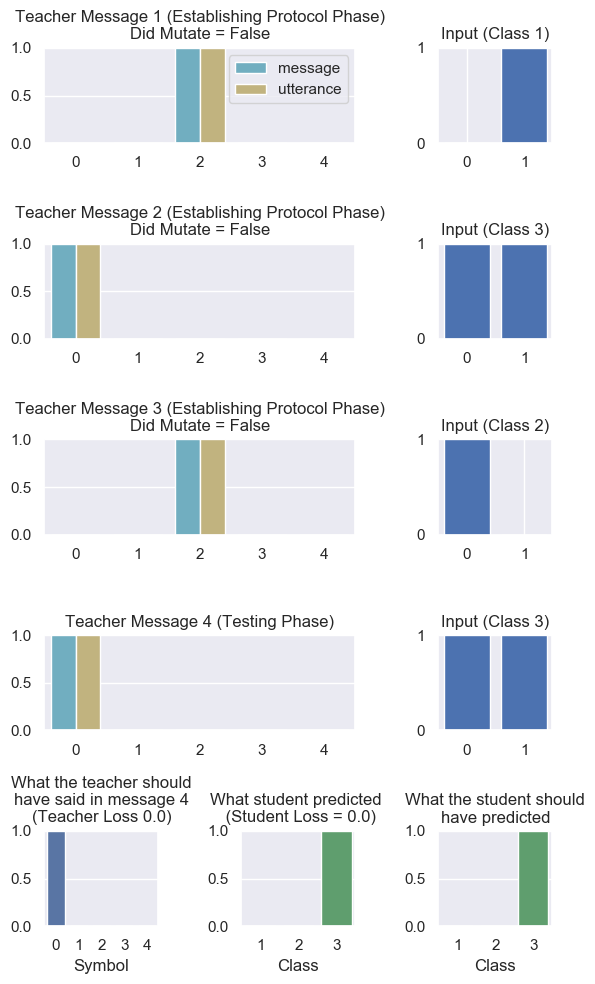

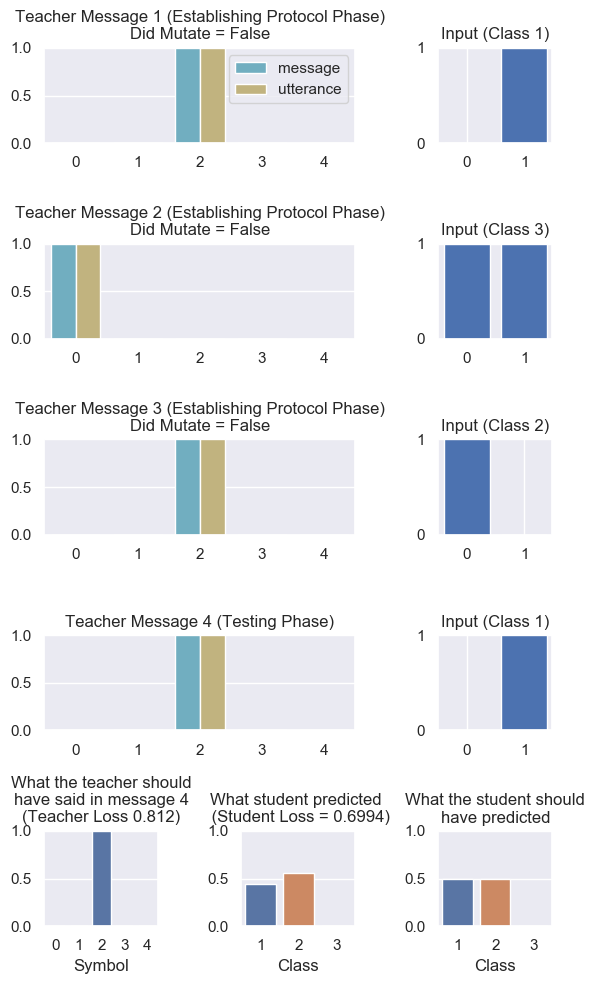

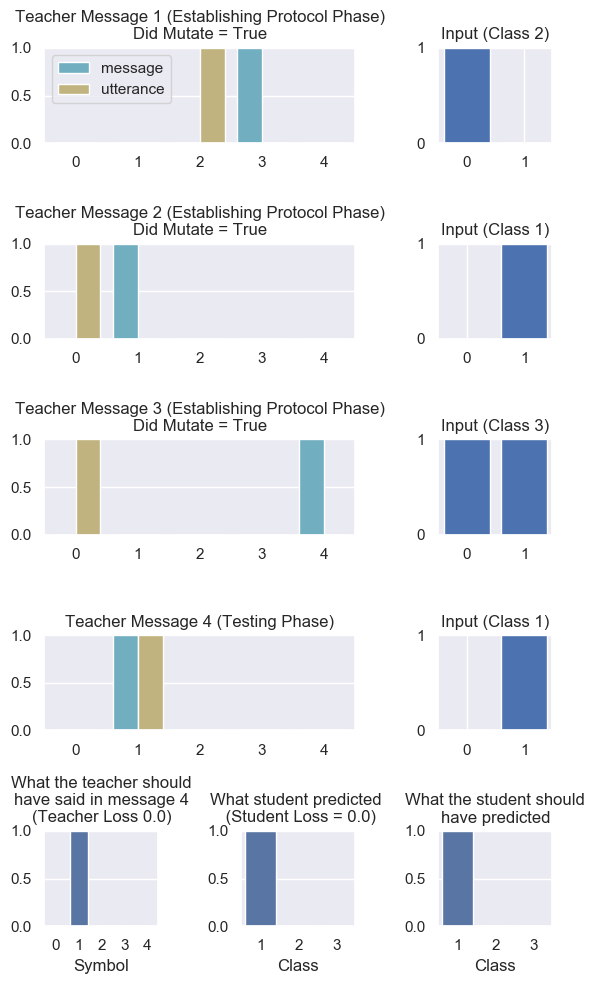

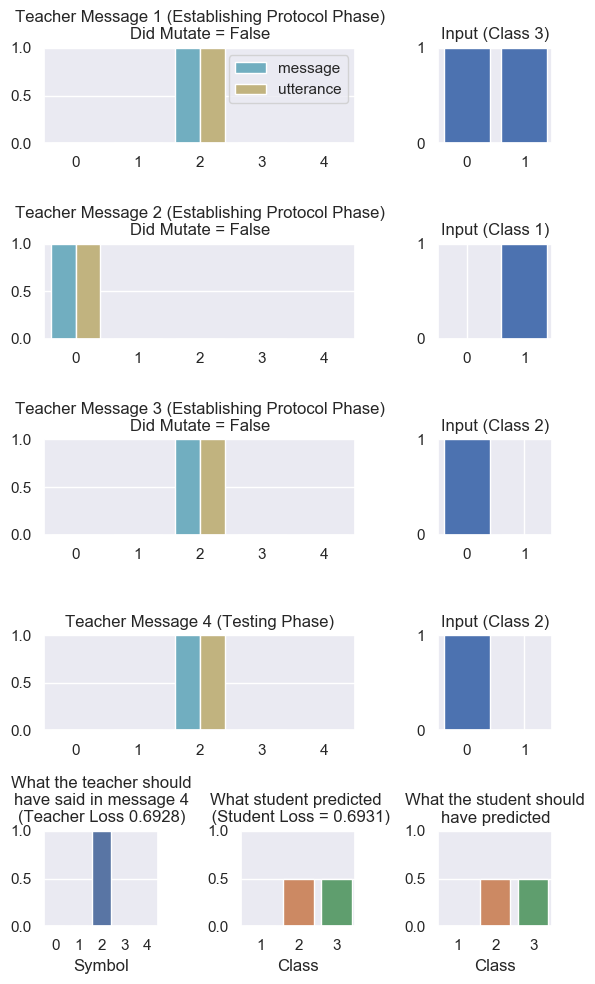

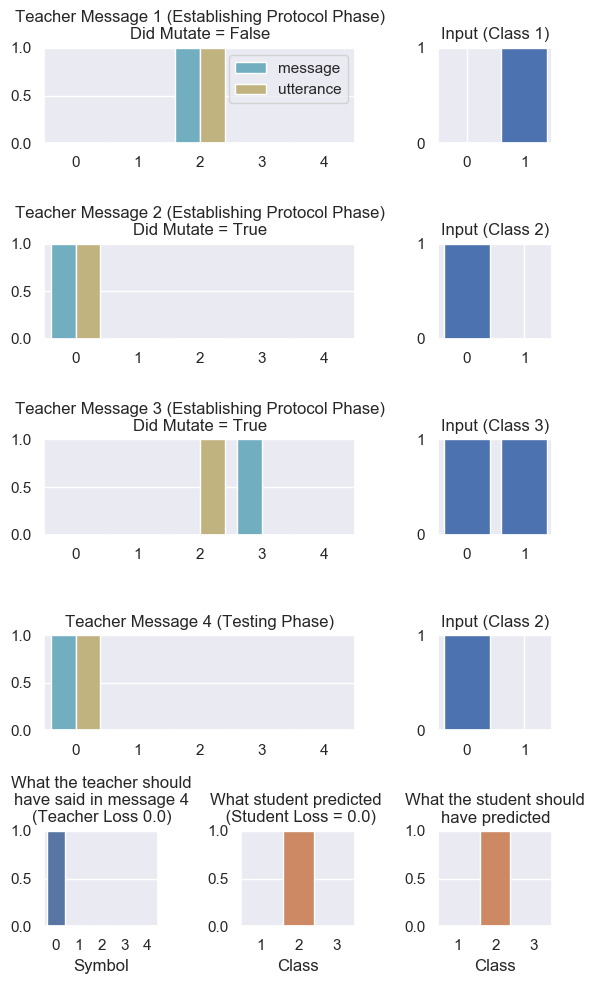

In [57]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=2)

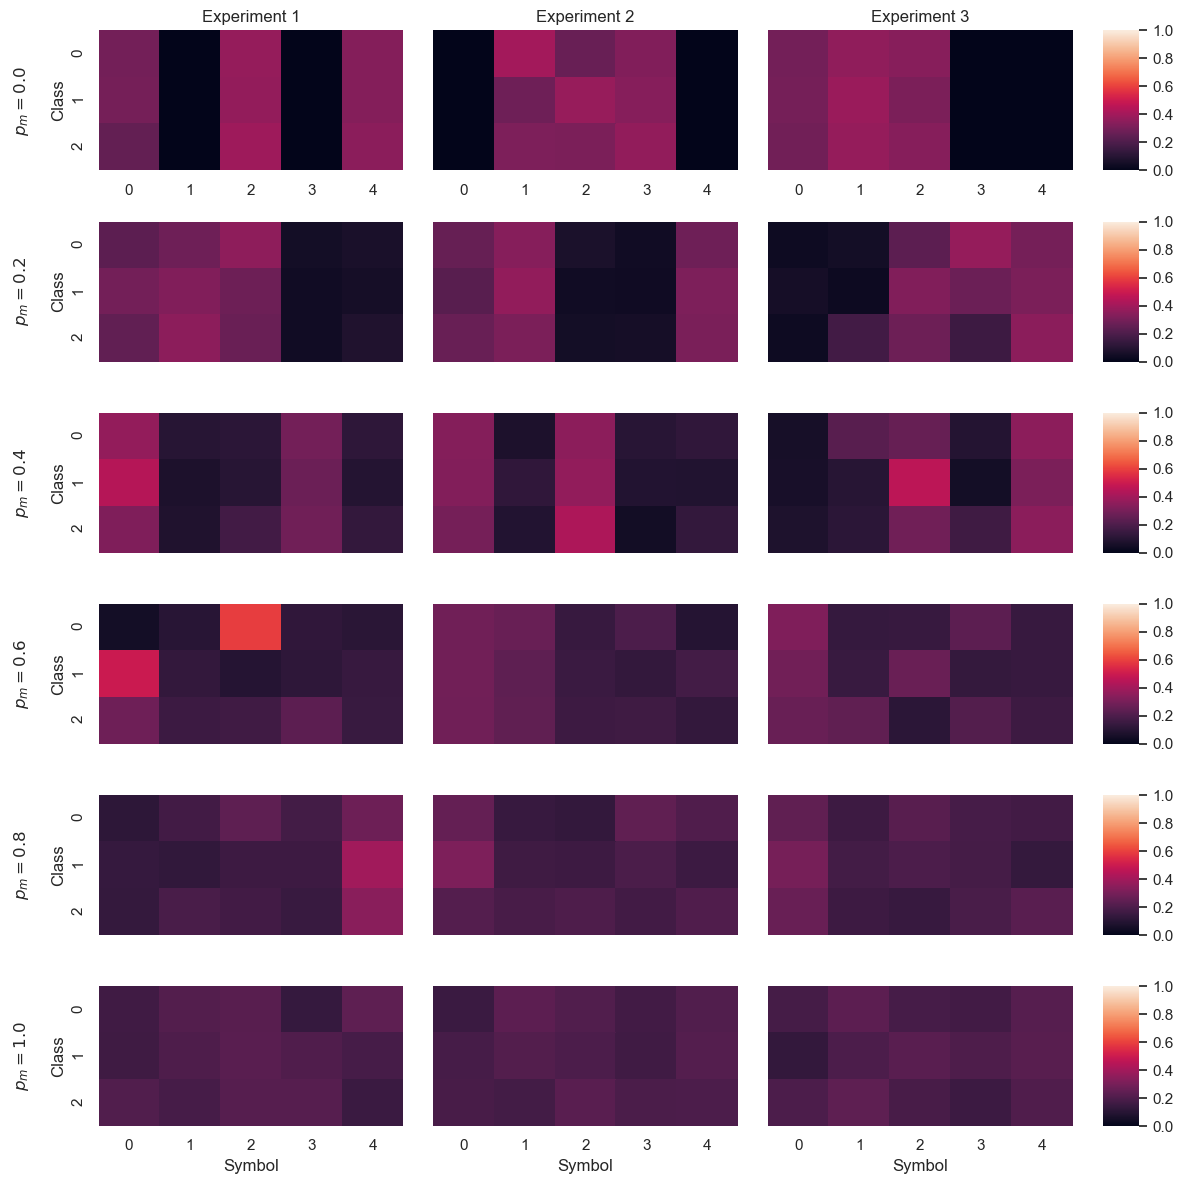

In [114]:
from matplotlib import gridspec

num_meta_experiments = len(vary_pm_experiment.experiments)
exps_per_meta = len(vary_pm_experiment.experiments[0]['experiment'].experiments)
fig = plt.figure(figsize=(2*2*exps_per_meta, 2*num_meta_experiments)) 


sqrs_per_plot = 5
gs = gridspec.GridSpec(num_meta_experiments, sqrs_per_plot*exps_per_meta+1)

for i in range(num_meta_experiments):
    meta_exp = vary_pm_experiment.experiments[i]['experiment']
    for j in range(exps_per_meta):
        sub_exp = meta_exp.experiments[j]['experiment']
        games_played, _ = sub_exp.run_tests()
        mean_class_message_map = create_mean_class_message_map(games_played)
        
        ax = plt.subplot(gs[i, sqrs_per_plot*j:sqrs_per_plot*(j+1)])
        
        last_col = j == exps_per_meta - 1
        cbar_ax = plt.subplot(gs[i, -1]) if last_col else None
            
        sns.heatmap(mean_class_message_map, vmin=0, vmax=1, ax=ax, 
                    cbar=last_col, cbar_ax=cbar_ax);
        
        if j == 0: 
            p_mutate = sub_exp.get_play_params().get('p_mutate', 0.0) 
            ax.set_ylabel(f'$p_m = {p_mutate}$\n\nClass')
        else: 
            ax.set_yticks([])
         
        if i == 0:
            ax.set_title(f'Experiment {j+1}')
        elif i == num_meta_experiments - 1:
            ax.set_xlabel('Symbol')
        else:
            ax.set_xticks([])

plt.tight_layout()
plt.show()

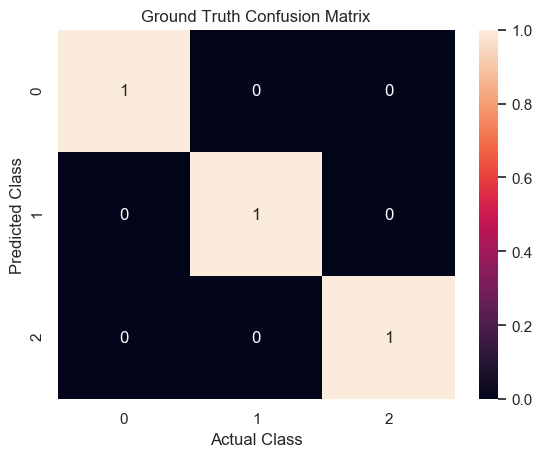

In [52]:
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')
plt.show()